# Training a Swin transformer model to predict layer annotations

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from transformers import TFSwinModel
import datetime
from sklearn.model_selection import train_test_split
print(tf.__version__)

2025-07-16 17:40:01.682644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752702001.695665   30819 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752702001.700110   30819 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-16 17:40:01.713389: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/suraj/anaconda3/envs/vision-2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.18.1


In [2]:
with h5py.File('/home/suraj/Git/SCR-Progression/Duke_Control_processed.h5', 'r') as f:
    images = f['images'][:]  # shape: (N, 224, 224)
    layer_maps = f['layer_maps'][:]  # shape: (N, 224, 2) or (N, 224, 3)

In [3]:
# add another dimension to images for compatibility
if images.ndim == 3:
    images = np.expand_dims(images, axis=-1)

# We only want ILM and BM (first and last columns) for training
layer_maps = layer_maps[:, :, [0, 2]]  # if shape is (N, 224, 3)

In [4]:
#Testing with only 1000 samples
#images = images[:1000]
#layer_maps = layer_maps[:1000]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    images, layer_maps, test_size=0.2, random_state=42
)

In [6]:
if X_train.shape[-1] == 1:
    X_train = np.repeat(X_train, 3, axis=-1)
if X_test.shape[-1] == 1:
    X_test = np.repeat(X_test, 3, axis=-1)

print("X_train shape after conversion:", X_train.shape)
print("X_test shape after conversion:", X_test.shape)

X_train shape after conversion: (4070, 224, 224, 3)
X_test shape after conversion: (1018, 224, 224, 3)


In [7]:
# Load Swin-Tiny base model for feature extraction
swin_model = TFSwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
print("Swin model loaded successfully!")
print(f"Model expected channels: {swin_model.config.num_channels}")
print(f"Model input size: {swin_model.config.image_size}")

# The issue might be with tensor format - Swin expects NCHW (channels first) format
# Let's try transposing the tensor from NHWC to NCHW
test_batch = X_train[:2]  # Take 2 samples
print(f"Original batch shape: {test_batch.shape}")

# Normalize first
test_batch_norm = test_batch.astype(np.float32) / 255.0

# Transpose from NHWC to NCHW (TensorFlow to PyTorch format)
test_batch_transposed = np.transpose(test_batch_norm, (0, 3, 1, 2))
print(f"Transposed batch shape: {test_batch_transposed.shape}")

test_batch_tensor = tf.convert_to_tensor(test_batch_transposed, dtype=tf.float32)
print(f"Final tensor shape: {test_batch_tensor.shape}")
print(f"Final tensor dtype: {test_batch_tensor.dtype}")

# Try to run the model on this transposed batch
try:
    outputs = swin_model({"pixel_values": test_batch_tensor})
    print("Model ran successfully with transposed input!")
    print(f"Output shape: {outputs.last_hidden_state.shape}")
except Exception as e:
    print(f"Error with transposed input: {e}")
    
    # If that doesn't work, let's try with the original NHWC format but ensure proper preprocessing
    print("\nTrying original format with proper preprocessing...")
    test_batch_original = tf.convert_to_tensor(test_batch_norm, dtype=tf.float32)
    
    try:
        outputs = swin_model(test_batch_original)  # Try without dict wrapper
        print("Model ran successfully with direct tensor input!")
        print(f"Output shape: {outputs.last_hidden_state.shape}")
    except Exception as e2:
        print(f"Error with direct input: {e2}")
        
        # Try with different preprocessing
        print("\nTrying with ImageNet normalization...")
        # ImageNet normalization
        mean = tf.constant([0.485, 0.456, 0.406])
        std = tf.constant([0.229, 0.224, 0.225])
        
        test_batch_imagenet = (test_batch_norm - mean) / std
        test_batch_imagenet_tensor = tf.convert_to_tensor(test_batch_imagenet, dtype=tf.float32)
        
        try:
            outputs = swin_model({"pixel_values": test_batch_imagenet_tensor})
            print("Model ran successfully with ImageNet normalization!")
            print(f"Output shape: {outputs.last_hidden_state.shape}")
        except Exception as e3:
            print(f"Error with ImageNet normalization: {e3}")


I0000 00:00:1752702012.089520   30819 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1752702012.090677   30819 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 754 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFSwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFSwinModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSwinModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).


All the weights of TFSwinModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSwinModel for predictions without further training.


I0000 00:00:1752702013.606302   30819 cuda_dnn.cc:529] Loaded cuDNN version 90101


Swin model loaded successfully!
Model expected channels: 3
Model input size: 224
Original batch shape: (2, 224, 224, 3)
Transposed batch shape: (2, 3, 224, 224)
Final tensor shape: (2, 3, 224, 224)
Final tensor dtype: <dtype: 'float32'>


Model ran successfully with transposed input!
Output shape: (2, 49, 768)


In [8]:
def extract_swin_features(images, base_model, batch_size=8):
    """
    Extract features from images using Swin Transformer
    """
    features = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        
        # Ensure we have RGB channels (should already be done)
        if batch.shape[-1] == 1:
            batch_rgb = np.repeat(batch, 3, axis=-1)
        else:
            batch_rgb = batch
            
        # Convert to float32 and normalize to [0,1]
        batch_rgb = batch_rgb.astype(np.float32) / 255.0
        
        # Transpose from NHWC to NCHW format (TensorFlow to PyTorch format)
        batch_rgb = np.transpose(batch_rgb, (0, 3, 1, 2))
        
        # Convert to TensorFlow tensor
        batch_rgb = tf.convert_to_tensor(batch_rgb, dtype=tf.float32)
        
        # Extract features using Swin
        outputs = base_model({"pixel_values": batch_rgb})
        batch_features = outputs.last_hidden_state.numpy()
        features.extend(batch_features)
        
        if i % 100 == 0:
            print(f"Processed {i}/{len(images)} images")
            
    return np.array(features)

In [9]:
# Extract features from training and test data
print("Extracting features from training data")
X_train_features = extract_swin_features(X_train, swin_model, batch_size=8)

print("Extracting features from test data")
X_test_features = extract_swin_features(X_test, swin_model, batch_size=8)

print(f"Training features shape: {X_train_features.shape}")
print(f"Test features shape: {X_test_features.shape}")
print("Feature extraction completed!")

Extracting features from training data


Processed 0/4070 images


Processed 200/4070 images


Processed 400/4070 images


Processed 600/4070 images


Processed 800/4070 images


Processed 1000/4070 images


Processed 1200/4070 images


Processed 1400/4070 images


Processed 1600/4070 images


Processed 1800/4070 images


Processed 2000/4070 images


Processed 2200/4070 images


Processed 2400/4070 images


Processed 2600/4070 images


Processed 2800/4070 images


Processed 3000/4070 images


Processed 3200/4070 images


Processed 3400/4070 images


Processed 3600/4070 images


Processed 3800/4070 images


Processed 4000/4070 images


Extracting features from test data


Processed 0/1018 images


Processed 200/1018 images


Processed 400/1018 images


Processed 600/1018 images


Processed 800/1018 images


Processed 1000/1018 images


Training features shape: (4070, 49, 768)
Test features shape: (1018, 49, 768)
Feature extraction completed!


In [10]:
# Inspect Swin model configuration
print("Swin model configuration:")
print(swin_model.config)

# Verify input tensor shape
print("Input tensor shape:", X_train.shape)
print("Input tensor dtype:", X_train.dtype)

Swin model configuration:
SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linnet, Carpodacus mexicanus",
    "13": "junco, snowbird",
    "14": "indigo bu

In [11]:
# Create regression head for Swin features
def create_swin_regression_head(feature_shape):
    """
    Create a regression head that takes Swin features and predicts layer coordinates
    """
    input_layer = tf.keras.layers.Input(shape=feature_shape)
    
    # Global average pooling to reduce sequence dimension
    x = tf.keras.layers.GlobalAveragePooling1D()(input_layer)
    
    # Dense layers for regression
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    
    # Output layer: predict 224 points for 2 layers (ILM and BM)
    x = tf.keras.layers.Dense(224 * 2, activation='linear')(x)
    output = tf.keras.layers.Reshape((224, 2))(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=output)

# Create and compile Swin regression model
swin_regression_model = create_swin_regression_head(X_train_features.shape[1:])
swin_regression_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

print("Swin regression model created successfully!")
print(f"Input feature shape: {X_train_features.shape[1:]}")
print(f"Output shape: (224, 2)")
swin_regression_model.summary()

Swin regression model created successfully!
Input feature shape: (49, 768)
Output shape: (224, 2)
Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 49, 768)]         0         


 global_average_pooling1d (  (None, 768)               0         


 GlobalAveragePooling1D)                                         


 dense (Dense)               (None, 1024)              787456    


 dropout_24 (Dropout)        (None, 1024)              0         


 dense_1 (Dense)             (None, 512)               524800    


 dropout_25 (Dropout)        (None, 512)               0         


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 448)               115136    


 reshape (Reshape)           (None, 224, 2)            0         


Total params: 1558720 (5.95 MB)


Trainable params: 1558720 (5.95 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [12]:
# Create datasets for Swin features
swin_train_dataset = tf.data.Dataset.from_tensor_slices((X_train_features, y_train)).batch(16).shuffle(100)
swin_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_features, y_test)).batch(16)

# TensorBoard callback for Swin model
swin_log_dir = "logs/swin_fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
swin_tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=swin_log_dir, histogram_freq=1)

print("Starting Swin model training...")
# Train Swin regression model
swin_history = swin_regression_model.fit(
    swin_train_dataset,
    validation_data=swin_test_dataset, 
    epochs=50,  # Slightly more epochs since we have rich features
    callbacks=[swin_tensorboard_callback]
)

2025-07-16 17:43:57.600464: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 612648960 exceeds 10% of free system memory.
2025-07-16 17:43:57.943753: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 612648960 exceeds 10% of free system memory.


Starting Swin model training...


2025-07-16 17:43:58.533664: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 612648960 exceeds 10% of free system memory.


Epoch 1/50


I0000 00:00:1752702239.428691   30993 service.cc:148] XLA service 0x704fa0110de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752702239.428718   30993 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-07-16 17:43:59.433540: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752702239.511782   30993 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/255 [..............................] - ETA: 4:51 - loss: 0.3205 - mean_absolute_error: 0.5107

 16/255 [>.............................] - ETA: 0s - loss: 0.2692 - mean_absolute_error: 0.4577  

 32/255 [==>...........................] - ETA: 0s - loss: 0.2212 - mean_absolute_error: 0.3988

 48/255 [====>.........................] - ETA: 0s - loss: 0.1800 - mean_absolute_error: 0.3470

 64/255 [======>.......................] - ETA: 0s - loss: 0.1474 - mean_absolute_error: 0.3028

 80/255 [========>.....................] - ETA: 0s - loss: 0.1232 - mean_absolute_error: 0.2673

 96/255 [==========>...................] - ETA: 0s - loss: 0.1057 - mean_absolute_error: 0.2403

112/255 [============>.................] - ETA: 0s - loss: 0.0926 - mean_absolute_error: 0.2193

128/255 [==============>...............] - ETA: 0s - loss: 0.0825 - mean_absolute_error: 0.2028

144/255 [===============>..............] - ETA: 0s - loss: 0.0745 - mean_absolute_error: 0.1892

161/255 [=================>............] - ETA: 0s - loss: 0.0676 - mean_absolute_error: 0.1772

179/255 [====================>.........] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1670

197/255 [======================>.......] - ETA: 0s - loss: 0.0568 - mean_absolute_error: 0.1583

215/255 [========================>.....] - ETA: 0s - loss: 0.0527 - mean_absolute_error: 0.1507

233/255 [==========================>...] - ETA: 0s - loss: 0.0492 - mean_absolute_error: 0.1443

251/255 [============================>.] - ETA: 0s - loss: 0.0462 - mean_absolute_error: 0.1389

255/255 [==============================] - 2s 5ms/step - loss: 0.0456 - mean_absolute_error: 0.1378 - val_loss: 0.0026 - val_mean_absolute_error: 0.0381


Epoch 2/50


  1/255 [..............................] - ETA: 7s - loss: 0.0065 - mean_absolute_error: 0.0645

 17/255 [=>............................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0635

 33/255 [==>...........................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0639

 49/255 [====>.........................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0637

 65/255 [======>.......................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0633

 81/255 [========>.....................] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0624

 98/255 [==========>...................] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0619

114/255 [============>.................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0613

130/255 [==============>...............] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0609

146/255 [================>.............] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0606

162/255 [==================>...........] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0603

179/255 [====================>.........] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0599

197/255 [======================>.......] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0595

215/255 [========================>.....] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0595

233/255 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0592

251/255 [============================>.] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0590

255/255 [==============================] - 1s 4ms/step - loss: 0.0056 - mean_absolute_error: 0.0590 - val_loss: 0.0025 - val_mean_absolute_error: 0.0379


Epoch 3/50


  1/255 [..............................] - ETA: 7s - loss: 0.0043 - mean_absolute_error: 0.0529

 15/255 [>.............................] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0569

 31/255 [==>...........................] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0577

 48/255 [====>.........................] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0571

 64/255 [======>.......................] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0565

 80/255 [========>.....................] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0556

 97/255 [==========>...................] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0557

113/255 [============>.................] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0554

129/255 [==============>...............] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0554

145/255 [================>.............] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0553

162/255 [==================>...........] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0551

177/255 [===================>..........] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0548

195/255 [=====================>........] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0544

213/255 [========================>.....] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0539

231/255 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0536

249/255 [============================>.] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0534

255/255 [==============================] - 1s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0535 - val_loss: 0.0025 - val_mean_absolute_error: 0.0379


Epoch 4/50


  1/255 [..............................] - ETA: 7s - loss: 0.0039 - mean_absolute_error: 0.0497

 17/255 [=>............................] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0521

 32/255 [==>...........................] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0522

 48/255 [====>.........................] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0523

 64/255 [======>.......................] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0531

 80/255 [========>.....................] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0526

 96/255 [==========>...................] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0524

113/255 [============>.................] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0522

130/255 [==============>...............] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0519

147/255 [================>.............] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0521

164/255 [==================>...........] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0521

181/255 [====================>.........] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0519

199/255 [======================>.......] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0516

217/255 [========================>.....] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0515

235/255 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0512

253/255 [============================>.] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0512

255/255 [==============================] - 1s 4ms/step - loss: 0.0043 - mean_absolute_error: 0.0511 - val_loss: 0.0025 - val_mean_absolute_error: 0.0371


Epoch 5/50


  1/255 [..............................] - ETA: 7s - loss: 0.0034 - mean_absolute_error: 0.0462

 15/255 [>.............................] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0486

 30/255 [==>...........................] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0480

 47/255 [====>.........................] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0489

 63/255 [======>.......................] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0496

 79/255 [========>.....................] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0502

 95/255 [==========>...................] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0504

111/255 [============>.................] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0507

128/255 [==============>...............] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0508

144/255 [===============>..............] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0505

161/255 [=================>............] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0504

179/255 [====================>.........] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0504

197/255 [======================>.......] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0503

215/255 [========================>.....] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0505

233/255 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0503

251/255 [============================>.] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0501

255/255 [==============================] - 1s 4ms/step - loss: 0.0041 - mean_absolute_error: 0.0501 - val_loss: 0.0031 - val_mean_absolute_error: 0.0429


Epoch 6/50


  1/255 [..............................] - ETA: 7s - loss: 0.0045 - mean_absolute_error: 0.0506

 15/255 [>.............................] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0513

 31/255 [==>...........................] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0513

 47/255 [====>.........................] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0498

 63/255 [======>.......................] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0497

 79/255 [========>.....................] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0492

 95/255 [==========>...................] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0495

111/255 [============>.................] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0494

127/255 [=============>................] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0491

143/255 [===============>..............] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0491

160/255 [=================>............] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.0488

177/255 [===================>..........] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.0488

195/255 [=====================>........] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0491

213/255 [========================>.....] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.0489

231/255 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.0489

249/255 [============================>.] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.0488

255/255 [==============================] - 1s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0487 - val_loss: 0.0025 - val_mean_absolute_error: 0.0373


Epoch 7/50


  1/255 [..............................] - ETA: 7s - loss: 0.0028 - mean_absolute_error: 0.0425

 15/255 [>.............................] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.0426

 30/255 [==>...........................] - ETA: 0s - loss: 0.0035 - mean_absolute_error: 0.0461

 46/255 [====>.........................] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.0470

 63/255 [======>.......................] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0474

 80/255 [========>.....................] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0479

 96/255 [==========>...................] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0482

113/255 [============>.................] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0481

123/255 [=============>................] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0479

138/255 [===============>..............] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0481

154/255 [=================>............] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0478

172/255 [===================>..........] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0480

190/255 [=====================>........] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0481

208/255 [=======================>......] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0479

226/255 [=========================>....] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0478

244/255 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0477

255/255 [==============================] - 1s 4ms/step - loss: 0.0037 - mean_absolute_error: 0.0476 - val_loss: 0.0025 - val_mean_absolute_error: 0.0371


Epoch 8/50


  1/255 [..............................] - ETA: 7s - loss: 0.0065 - mean_absolute_error: 0.0619

 18/255 [=>............................] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0506

 34/255 [===>..........................] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0496

 50/255 [====>.........................] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0493

 66/255 [======>.......................] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.0485

 82/255 [========>.....................] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0479

 98/255 [==========>...................] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0476

114/255 [============>.................] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0473

129/255 [==============>...............] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.0468

146/255 [================>.............] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.0465

163/255 [==================>...........] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.0466

181/255 [====================>.........] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.0466

199/255 [======================>.......] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.0468

217/255 [========================>.....] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.0466

235/255 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.0465

253/255 [============================>.] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.0465

255/255 [==============================] - 1s 4ms/step - loss: 0.0036 - mean_absolute_error: 0.0464 - val_loss: 0.0030 - val_mean_absolute_error: 0.0432


Epoch 9/50


  1/255 [..............................] - ETA: 7s - loss: 0.0052 - mean_absolute_error: 0.0532

 14/255 [>.............................] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0452

 30/255 [==>...........................] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0451

 46/255 [====>.........................] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0455

 63/255 [======>.......................] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0450

 80/255 [========>.....................] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0452

 96/255 [==========>...................] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0453

112/255 [============>.................] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0450

128/255 [==============>...............] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0448

144/255 [===============>..............] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0448

161/255 [=================>............] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0450

179/255 [====================>.........] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0450

197/255 [======================>.......] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0450

215/255 [========================>.....] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0451

233/255 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0449

251/255 [============================>.] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0449

255/255 [==============================] - 1s 4ms/step - loss: 0.0034 - mean_absolute_error: 0.0449 - val_loss: 0.0027 - val_mean_absolute_error: 0.0384


Epoch 10/50


  1/255 [..............................] - ETA: 7s - loss: 0.0039 - mean_absolute_error: 0.0472

 15/255 [>.............................] - ETA: 0s - loss: 0.0035 - mean_absolute_error: 0.0452

 31/255 [==>...........................] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0446

 48/255 [====>.........................] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0452

 64/255 [======>.......................] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0446

 80/255 [========>.....................] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0445

 96/255 [==========>...................] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0445

112/255 [============>.................] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0443

128/255 [==============>...............] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0446

145/255 [================>.............] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0444

162/255 [==================>...........] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0441

180/255 [====================>.........] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.0439

198/255 [======================>.......] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.0439

216/255 [========================>.....] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.0439

234/255 [==========================>...] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.0440

252/255 [============================>.] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.0440

255/255 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0441 - val_loss: 0.0026 - val_mean_absolute_error: 0.0378


Epoch 11/50


  1/255 [..............................] - ETA: 7s - loss: 0.0024 - mean_absolute_error: 0.0390

 15/255 [>.............................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0406

 30/255 [==>...........................] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0423

 46/255 [====>.........................] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0429

 62/255 [======>.......................] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0427

 73/255 [=======>......................] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0429

 88/255 [=========>....................] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0431

104/255 [===========>..................] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0430

120/255 [=============>................] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0425

137/255 [===============>..............] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0423

153/255 [=================>............] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0424

171/255 [===================>..........] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0425

189/255 [=====================>........] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0425

207/255 [=======================>......] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0428

225/255 [=========================>....] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0427

243/255 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0428

255/255 [==============================] - 1s 4ms/step - loss: 0.0031 - mean_absolute_error: 0.0428 - val_loss: 0.0029 - val_mean_absolute_error: 0.0424


Epoch 12/50


  1/255 [..............................] - ETA: 7s - loss: 0.0039 - mean_absolute_error: 0.0490

 15/255 [>.............................] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0431

 31/255 [==>...........................] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.0434

 47/255 [====>.........................] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0427

 63/255 [======>.......................] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0423

 79/255 [========>.....................] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0422

 95/255 [==========>...................] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0423

111/255 [============>.................] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0425

127/255 [=============>................] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0423

143/255 [===============>..............] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0423

159/255 [=================>............] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0423

176/255 [===================>..........] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0421

194/255 [=====================>........] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0417

212/255 [=======================>......] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0418

230/255 [==========================>...] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0418

248/255 [============================>.] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.0416

255/255 [==============================] - 1s 4ms/step - loss: 0.0029 - mean_absolute_error: 0.0416 - val_loss: 0.0028 - val_mean_absolute_error: 0.0403


Epoch 13/50


  1/255 [..............................] - ETA: 7s - loss: 0.0022 - mean_absolute_error: 0.0362

 15/255 [>.............................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0396

 30/255 [==>...........................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0405

 46/255 [====>.........................] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.0408

 62/255 [======>.......................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0405

 78/255 [========>.....................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0404

 94/255 [==========>...................] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.0408

110/255 [===========>..................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0409

126/255 [=============>................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0408

142/255 [===============>..............] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0407

159/255 [=================>............] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0408

177/255 [===================>..........] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0408

195/255 [=====================>........] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.0409

213/255 [========================>.....] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0409

231/255 [==========================>...] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0408

249/255 [============================>.] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0407

255/255 [==============================] - 1s 4ms/step - loss: 0.0028 - mean_absolute_error: 0.0407 - val_loss: 0.0025 - val_mean_absolute_error: 0.0374


Epoch 14/50


  1/255 [..............................] - ETA: 7s - loss: 0.0049 - mean_absolute_error: 0.0491

 15/255 [>.............................] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.0416

 30/255 [==>...........................] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.0411

 46/255 [====>.........................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0406

 62/255 [======>.......................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0401

 78/255 [========>.....................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0402

 94/255 [==========>...................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0397

110/255 [===========>..................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0395

126/255 [=============>................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0395

142/255 [===============>..............] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0395

158/255 [=================>............] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0395

175/255 [===================>..........] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0394

193/255 [=====================>........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0393

211/255 [=======================>......] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0394

229/255 [=========================>....] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0395

247/255 [============================>.] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0395

255/255 [==============================] - 1s 4ms/step - loss: 0.0027 - mean_absolute_error: 0.0395 - val_loss: 0.0025 - val_mean_absolute_error: 0.0380


Epoch 15/50


  1/255 [..............................] - ETA: 7s - loss: 0.0023 - mean_absolute_error: 0.0370

 14/255 [>.............................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0394

 27/255 [==>...........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

 43/255 [====>.........................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0396

 59/255 [=====>........................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0401

 76/255 [=======>......................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0395

 92/255 [=========>....................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0394

108/255 [===========>..................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0389

124/255 [=============>................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0392

140/255 [===============>..............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0390

156/255 [=================>............] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0392

173/255 [===================>..........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0391

191/255 [=====================>........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0389

209/255 [=======================>......] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

227/255 [=========================>....] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

245/255 [===========================>..] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

255/255 [==============================] - 1s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0387 - val_loss: 0.0025 - val_mean_absolute_error: 0.0371


Epoch 16/50


  1/255 [..............................] - ETA: 7s - loss: 0.0022 - mean_absolute_error: 0.0383

 15/255 [>.............................] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0415

 30/255 [==>...........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0393

 46/255 [====>.........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

 62/255 [======>.......................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

 79/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

 95/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

111/255 [============>.................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

127/255 [=============>................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

144/255 [===============>..............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

160/255 [=================>............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

177/255 [===================>..........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

195/255 [=====================>........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

213/255 [========================>.....] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

231/255 [==========================>...] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

249/255 [============================>.] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

255/255 [==============================] - 1s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0386 - val_loss: 0.0025 - val_mean_absolute_error: 0.0376


Epoch 17/50


  1/255 [..............................] - ETA: 7s - loss: 0.0050 - mean_absolute_error: 0.0530

 17/255 [=>............................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0393

 33/255 [==>...........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0393

 49/255 [====>.........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0392

 65/255 [======>.......................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0393

 81/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0390

 98/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

115/255 [============>.................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

131/255 [==============>...............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

148/255 [================>.............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

165/255 [==================>...........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

183/255 [====================>.........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

201/255 [======================>.......] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

219/255 [========================>.....] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

237/255 [==========================>...] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

254/255 [============================>.] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

255/255 [==============================] - 1s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0387 - val_loss: 0.0025 - val_mean_absolute_error: 0.0368


Epoch 18/50


  1/255 [..............................] - ETA: 7s - loss: 0.0030 - mean_absolute_error: 0.0408

 15/255 [>.............................] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.0406

 31/255 [==>...........................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0402

 47/255 [====>.........................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0398

 63/255 [======>.......................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0398

 79/255 [========>.....................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0397

 96/255 [==========>...................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0394

112/255 [============>.................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0389

128/255 [==============>...............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

144/255 [===============>..............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

161/255 [=================>............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

179/255 [====================>.........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

197/255 [======================>.......] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

215/255 [========================>.....] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

233/255 [==========================>...] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

240/255 [===========================>..] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

255/255 [==============================] - 1s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0386 - val_loss: 0.0025 - val_mean_absolute_error: 0.0372


Epoch 19/50


  1/255 [..............................] - ETA: 8s - loss: 0.0020 - mean_absolute_error: 0.0353

 16/255 [>.............................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0374

 32/255 [==>...........................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0375

 48/255 [====>.........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0377

 64/255 [======>.......................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

 80/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

 96/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

112/255 [============>.................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

129/255 [==============>...............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

145/255 [================>.............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

162/255 [==================>...........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

180/255 [====================>.........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

198/255 [======================>.......] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

216/255 [========================>.....] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

234/255 [==========================>...] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

252/255 [============================>.] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

255/255 [==============================] - 1s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0386 - val_loss: 0.0025 - val_mean_absolute_error: 0.0371


Epoch 20/50


  1/255 [..............................] - ETA: 7s - loss: 0.0023 - mean_absolute_error: 0.0364

 14/255 [>.............................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0401

 29/255 [==>...........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0394

 45/255 [====>.........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

 61/255 [======>.......................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0383

 78/255 [========>.....................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

 95/255 [==========>...................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0383

111/255 [============>.................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0384

127/255 [=============>................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0383

143/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0384

160/255 [=================>............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

177/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0383

194/255 [=====================>........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

211/255 [=======================>......] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

229/255 [=========================>....] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

247/255 [============================>.] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

255/255 [==============================] - 1s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0385 - val_loss: 0.0025 - val_mean_absolute_error: 0.0371


Epoch 21/50


  1/255 [..............................] - ETA: 7s - loss: 0.0025 - mean_absolute_error: 0.0391

 15/255 [>.............................] - ETA: 0s - loss: 0.0022 - mean_absolute_error: 0.0360

 31/255 [==>...........................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0368

 47/255 [====>.........................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

 63/255 [======>.......................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

 79/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

 95/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

111/255 [============>.................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

127/255 [=============>................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

143/255 [===============>..............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

159/255 [=================>............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

176/255 [===================>..........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

194/255 [=====================>........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

212/255 [=======================>......] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

230/255 [==========================>...] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

248/255 [============================>.] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

255/255 [==============================] - 1s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0385 - val_loss: 0.0025 - val_mean_absolute_error: 0.0370


Epoch 22/50


  1/255 [..............................] - ETA: 7s - loss: 0.0033 - mean_absolute_error: 0.0442

 17/255 [=>............................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0390

 33/255 [==>...........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

 49/255 [====>.........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0391

 65/255 [======>.......................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

 81/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

 97/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

113/255 [============>.................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

129/255 [==============>...............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

146/255 [================>.............] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0391

163/255 [==================>...........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0389

180/255 [====================>.........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

191/255 [=====================>........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

208/255 [=======================>......] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

226/255 [=========================>....] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

244/255 [===========================>..] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

255/255 [==============================] - 1s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0384 - val_loss: 0.0025 - val_mean_absolute_error: 0.0364


Epoch 23/50


  1/255 [..............................] - ETA: 8s - loss: 0.0025 - mean_absolute_error: 0.0403

 16/255 [>.............................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0380

 32/255 [==>...........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

 48/255 [====>.........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

 64/255 [======>.......................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0385

 80/255 [========>.....................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0384

 96/255 [==========>...................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0383

112/255 [============>.................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0384

128/255 [==============>...............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0382

144/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

160/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0383

178/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0383

196/255 [======================>.......] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

214/255 [========================>.....] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

232/255 [==========================>...] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

250/255 [============================>.] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

255/255 [==============================] - 1s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0384 - val_loss: 0.0025 - val_mean_absolute_error: 0.0379


Epoch 24/50


  1/255 [..............................] - ETA: 7s - loss: 0.0035 - mean_absolute_error: 0.0440

 15/255 [>.............................] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.0408

 31/255 [==>...........................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0401

 47/255 [====>.........................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0400

 63/255 [======>.......................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0391

 79/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

 95/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

111/255 [============>.................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0382

127/255 [=============>................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

143/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

159/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0382

177/255 [===================>..........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

195/255 [=====================>........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0382

213/255 [========================>.....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0382

231/255 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0382

249/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0382

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0382 - val_loss: 0.0025 - val_mean_absolute_error: 0.0371


Epoch 25/50


  1/255 [..............................] - ETA: 7s - loss: 0.0032 - mean_absolute_error: 0.0389

 15/255 [>.............................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0372

 30/255 [==>...........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

 46/255 [====>.........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0386

 62/255 [======>.......................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

 78/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

 94/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

110/255 [===========>..................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

126/255 [=============>................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

142/255 [===============>..............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

158/255 [=================>............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

176/255 [===================>..........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

194/255 [=====================>........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

212/255 [=======================>......] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

230/255 [==========================>...] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

248/255 [============================>.] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0382 - val_loss: 0.0025 - val_mean_absolute_error: 0.0367


Epoch 26/50


  1/255 [..............................] - ETA: 7s - loss: 0.0018 - mean_absolute_error: 0.0327

 15/255 [>.............................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0392

 30/255 [==>...........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

 46/255 [====>.........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0393

 62/255 [======>.......................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0400

 78/255 [========>.....................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0391

 94/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0389

110/255 [===========>..................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

127/255 [=============>................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

143/255 [===============>..............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

159/255 [=================>............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

176/255 [===================>..........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

194/255 [=====================>........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

212/255 [=======================>......] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

229/255 [=========================>....] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

247/255 [============================>.] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0383 - val_loss: 0.0025 - val_mean_absolute_error: 0.0369


Epoch 27/50


  1/255 [..............................] - ETA: 7s - loss: 0.0024 - mean_absolute_error: 0.0388

 15/255 [>.............................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0377

 30/255 [==>...........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

 46/255 [====>.........................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0375

 62/255 [======>.......................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0376

 78/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0381

 94/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0381

110/255 [===========>..................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0381

126/255 [=============>................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

142/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

158/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

175/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

193/255 [=====================>........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

211/255 [=======================>......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

229/255 [=========================>....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

247/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0382

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0382 - val_loss: 0.0025 - val_mean_absolute_error: 0.0377


Epoch 28/50


  1/255 [..............................] - ETA: 7s - loss: 0.0029 - mean_absolute_error: 0.0411

 15/255 [>.............................] - ETA: 0s - loss: 0.0021 - mean_absolute_error: 0.0354

 31/255 [==>...........................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

 47/255 [====>.........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

 63/255 [======>.......................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0387

 79/255 [========>.....................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0389

 95/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

111/255 [============>.................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

127/255 [=============>................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

144/255 [===============>..............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

161/255 [=================>............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

179/255 [====================>.........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

197/255 [======================>.......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

215/255 [========================>.....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

233/255 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

251/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0381 - val_loss: 0.0025 - val_mean_absolute_error: 0.0376


Epoch 29/50


  1/255 [..............................] - ETA: 7s - loss: 0.0035 - mean_absolute_error: 0.0444

 15/255 [>.............................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

 31/255 [==>...........................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0368

 47/255 [====>.........................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0366

 63/255 [======>.......................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0369

 79/255 [========>.....................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0372

 95/255 [==========>...................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0374

111/255 [============>.................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0374

127/255 [=============>................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

143/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

159/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

176/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

194/255 [=====================>........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

212/255 [=======================>......] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

230/255 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

248/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0381 - val_loss: 0.0025 - val_mean_absolute_error: 0.0370


Epoch 30/50


  1/255 [..............................] - ETA: 7s - loss: 0.0034 - mean_absolute_error: 0.0432

 15/255 [>.............................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0393

 31/255 [==>...........................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0399

 47/255 [====>.........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

 63/255 [======>.......................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

 78/255 [========>.....................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

 94/255 [==========>...................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

107/255 [===========>..................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

124/255 [=============>................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

140/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

156/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

174/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

192/255 [=====================>........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

210/255 [=======================>......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

228/255 [=========================>....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

246/255 [===========================>..] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0380 - val_loss: 0.0025 - val_mean_absolute_error: 0.0373


Epoch 31/50


  1/255 [..............................] - ETA: 7s - loss: 0.0020 - mean_absolute_error: 0.0343

 15/255 [>.............................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0398

 31/255 [==>...........................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0385

 47/255 [====>.........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0389

 63/255 [======>.......................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

 79/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

 95/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

111/255 [============>.................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

127/255 [=============>................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0381

143/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

160/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

177/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

195/255 [=====================>........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

213/255 [========================>.....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

231/255 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

249/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0381 - val_loss: 0.0025 - val_mean_absolute_error: 0.0375


Epoch 32/50


  1/255 [..............................] - ETA: 7s - loss: 0.0023 - mean_absolute_error: 0.0371

 17/255 [=>............................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0371

 33/255 [==>...........................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0370

 49/255 [====>.........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

 65/255 [======>.......................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

 81/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

 97/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

113/255 [============>.................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

129/255 [==============>...............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

145/255 [================>.............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

162/255 [==================>...........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

179/255 [====================>.........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

197/255 [======================>.......] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

215/255 [========================>.....] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

233/255 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0382

251/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0381 - val_loss: 0.0025 - val_mean_absolute_error: 0.0367


Epoch 33/50


  1/255 [..............................] - ETA: 7s - loss: 0.0020 - mean_absolute_error: 0.0343

 15/255 [>.............................] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0365

 30/255 [==>...........................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0373

 46/255 [====>.........................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0376

 62/255 [======>.......................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

 78/255 [========>.....................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

 94/255 [==========>...................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

111/255 [============>.................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

127/255 [=============>................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

143/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

159/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

177/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0382

195/255 [=====================>........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

213/255 [========================>.....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

231/255 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

249/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0381 - val_loss: 0.0025 - val_mean_absolute_error: 0.0380


Epoch 34/50


  1/255 [..............................] - ETA: 7s - loss: 0.0039 - mean_absolute_error: 0.0463

 15/255 [>.............................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

 31/255 [==>...........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

 47/255 [====>.........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

 63/255 [======>.......................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0380

 79/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

 95/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

111/255 [============>.................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0381

126/255 [=============>................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

142/255 [===============>..............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

158/255 [=================>............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

175/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

193/255 [=====================>........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

211/255 [=======================>......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

229/255 [=========================>....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

246/255 [===========================>..] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0380 - val_loss: 0.0025 - val_mean_absolute_error: 0.0372


Epoch 35/50


  1/255 [..............................] - ETA: 7s - loss: 0.0036 - mean_absolute_error: 0.0428

 15/255 [>.............................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0397

 31/255 [==>...........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0393

 47/255 [====>.........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0394

 63/255 [======>.......................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

 79/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

 95/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

112/255 [============>.................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0390

128/255 [==============>...............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

144/255 [===============>..............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

160/255 [=================>............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0381

178/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

195/255 [=====================>........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

213/255 [========================>.....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

231/255 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

249/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0379 - val_loss: 0.0025 - val_mean_absolute_error: 0.0377


Epoch 36/50


  1/255 [..............................] - ETA: 7s - loss: 0.0022 - mean_absolute_error: 0.0377

 17/255 [=>............................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0394

 33/255 [==>...........................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

 49/255 [====>.........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

 65/255 [======>.......................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0382

 81/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0386

 97/255 [==========>...................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0383

113/255 [============>.................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

129/255 [==============>...............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

145/255 [================>.............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0382

161/255 [=================>............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

178/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0383

195/255 [=====================>........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

212/255 [=======================>......] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

230/255 [==========================>...] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

247/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0379 - val_loss: 0.0025 - val_mean_absolute_error: 0.0363


Epoch 37/50


  1/255 [..............................] - ETA: 7s - loss: 0.0020 - mean_absolute_error: 0.0352

 15/255 [>.............................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

 31/255 [==>...........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

 47/255 [====>.........................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0376

 63/255 [======>.......................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0381

 79/255 [========>.....................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

 95/255 [==========>...................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

111/255 [============>.................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

127/255 [=============>................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

143/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

160/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

178/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

196/255 [======================>.......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

214/255 [========================>.....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

232/255 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

250/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0378 - val_loss: 0.0025 - val_mean_absolute_error: 0.0369


Epoch 38/50


  1/255 [..............................] - ETA: 7s - loss: 0.0032 - mean_absolute_error: 0.0439

 17/255 [=>............................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0388

 33/255 [==>...........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0390

 48/255 [====>.........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0389

 64/255 [======>.......................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0394

 80/255 [========>.....................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0389

 96/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

112/255 [============>.................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

128/255 [==============>...............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

144/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

160/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

178/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

196/255 [======================>.......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

214/255 [========================>.....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

232/255 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

250/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0379 - val_loss: 0.0025 - val_mean_absolute_error: 0.0371


Epoch 39/50


  1/255 [..............................] - ETA: 7s - loss: 0.0020 - mean_absolute_error: 0.0340

 14/255 [>.............................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0394

 29/255 [==>...........................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0383

 45/255 [====>.........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0387

 61/255 [======>.......................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

 77/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

 92/255 [=========>....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

108/255 [===========>..................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0381

124/255 [=============>................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

140/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

156/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

173/255 [===================>..........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

191/255 [=====================>........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

209/255 [=======================>......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

226/255 [=========================>....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

243/255 [===========================>..] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0378 - val_loss: 0.0025 - val_mean_absolute_error: 0.0369


Epoch 40/50


  1/255 [..............................] - ETA: 7s - loss: 0.0019 - mean_absolute_error: 0.0343

 15/255 [>.............................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0388

 30/255 [==>...........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0390

 46/255 [====>.........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

 63/255 [======>.......................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

 79/255 [========>.....................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

 95/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

111/255 [============>.................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

127/255 [=============>................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

143/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

160/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

178/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

196/255 [======================>.......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

214/255 [========================>.....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

232/255 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

250/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0379 - val_loss: 0.0025 - val_mean_absolute_error: 0.0370


Epoch 41/50


  1/255 [..............................] - ETA: 7s - loss: 0.0037 - mean_absolute_error: 0.0434

 18/255 [=>............................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0382

 35/255 [===>..........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0387

 52/255 [=====>........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0379

 68/255 [=======>......................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0379

 84/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

100/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

116/255 [============>.................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

133/255 [==============>...............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0374

149/255 [================>.............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0375

166/255 [==================>...........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0376

184/255 [====================>.........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

202/255 [======================>.......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

213/255 [========================>.....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

230/255 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

248/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0377 - val_loss: 0.0025 - val_mean_absolute_error: 0.0368


Epoch 42/50


  1/255 [..............................] - ETA: 7s - loss: 0.0014 - mean_absolute_error: 0.0294

 17/255 [=>............................] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.0398

 33/255 [==>...........................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0396

 49/255 [====>.........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0388

 65/255 [======>.......................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

 81/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

 97/255 [==========>...................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

114/255 [============>.................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0382

130/255 [==============>...............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

146/255 [================>.............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

162/255 [==================>...........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

180/255 [====================>.........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

198/255 [======================>.......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

216/255 [========================>.....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

234/255 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

252/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0378 - val_loss: 0.0025 - val_mean_absolute_error: 0.0370


Epoch 43/50


  1/255 [..............................] - ETA: 7s - loss: 0.0015 - mean_absolute_error: 0.0308

 17/255 [=>............................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

 32/255 [==>...........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0391

 48/255 [====>.........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0389

 63/255 [======>.......................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0391

 79/255 [========>.....................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0389

 96/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

112/255 [============>.................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0382

128/255 [==============>...............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

144/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

159/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

176/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0376

194/255 [=====================>........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

212/255 [=======================>......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

230/255 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

248/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0378 - val_loss: 0.0025 - val_mean_absolute_error: 0.0368


Epoch 44/50


  1/255 [..............................] - ETA: 7s - loss: 0.0031 - mean_absolute_error: 0.0416

 14/255 [>.............................] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0368

 29/255 [==>...........................] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0363

 45/255 [====>.........................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0374

 61/255 [======>.......................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0376

 77/255 [========>.....................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

 93/255 [=========>....................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

109/255 [===========>..................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

125/255 [=============>................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

141/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

157/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

174/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

192/255 [=====================>........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0376

209/255 [=======================>......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0375

226/255 [=========================>....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0375

243/255 [===========================>..] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0376

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0377 - val_loss: 0.0025 - val_mean_absolute_error: 0.0376


Epoch 45/50


  1/255 [..............................] - ETA: 7s - loss: 0.0014 - mean_absolute_error: 0.0306

 15/255 [>.............................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0381

 31/255 [==>...........................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

 47/255 [====>.........................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0372

 63/255 [======>.......................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0369

 79/255 [========>.....................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0373

 96/255 [==========>...................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

112/255 [============>.................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0381

129/255 [==============>...............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

145/255 [================>.............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

162/255 [==================>...........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0381

169/255 [==================>...........] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0381

186/255 [====================>.........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

204/255 [=======================>......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

222/255 [=========================>....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

240/255 [===========================>..] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0376

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0377 - val_loss: 0.0025 - val_mean_absolute_error: 0.0375


Epoch 46/50


  1/255 [..............................] - ETA: 7s - loss: 0.0016 - mean_absolute_error: 0.0308

 16/255 [>.............................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0365

 32/255 [==>...........................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0371

 48/255 [====>.........................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0370

 64/255 [======>.......................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

 80/255 [========>.....................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

 97/255 [==========>...................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

113/255 [============>.................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

129/255 [==============>...............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

145/255 [================>.............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

162/255 [==================>...........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

180/255 [====================>.........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

198/255 [======================>.......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

216/255 [========================>.....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

234/255 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

252/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0376

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0376 - val_loss: 0.0025 - val_mean_absolute_error: 0.0366


Epoch 47/50


  1/255 [..............................] - ETA: 8s - loss: 0.0028 - mean_absolute_error: 0.0401

 14/255 [>.............................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0368

 30/255 [==>...........................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0375

 46/255 [====>.........................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0370

 62/255 [======>.......................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0367

 77/255 [========>.....................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0375

 94/255 [==========>...................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

110/255 [===========>..................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

126/255 [=============>................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

142/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

158/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

175/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

193/255 [=====================>........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

211/255 [=======================>......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

229/255 [=========================>....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

247/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0376 - val_loss: 0.0025 - val_mean_absolute_error: 0.0365


Epoch 48/50


  1/255 [..............................] - ETA: 8s - loss: 0.0020 - mean_absolute_error: 0.0332

 15/255 [>.............................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0372

 31/255 [==>...........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0394

 47/255 [====>.........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0392

 63/255 [======>.......................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0383

 79/255 [========>.....................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

 95/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0383

111/255 [============>.................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

127/255 [=============>................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

143/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0375

160/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0374

178/255 [===================>..........] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0373

196/255 [======================>.......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0373

213/255 [========================>.....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0374

230/255 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0374

247/255 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0376

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0376 - val_loss: 0.0025 - val_mean_absolute_error: 0.0376


Epoch 49/50


  1/255 [..............................] - ETA: 7s - loss: 0.0027 - mean_absolute_error: 0.0404

 14/255 [>.............................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0363

 30/255 [==>...........................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0371

 46/255 [====>.........................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0370

 62/255 [======>.......................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0368

 79/255 [========>.....................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0373

 95/255 [==========>...................] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0374

111/255 [============>.................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0376

122/255 [=============>................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0375

138/255 [===============>..............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0376

154/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

172/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0376

190/255 [=====================>........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

208/255 [=======================>......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

226/255 [=========================>....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0377

244/255 [===========================>..] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0378

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0376 - val_loss: 0.0025 - val_mean_absolute_error: 0.0370


Epoch 50/50


  1/255 [..............................] - ETA: 7s - loss: 0.0023 - mean_absolute_error: 0.0388

 15/255 [>.............................] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.0401

 31/255 [==>...........................] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0395

 47/255 [====>.........................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0395

 63/255 [======>.......................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0397

 80/255 [========>.....................] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0393

 96/255 [==========>...................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0387

112/255 [============>.................] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0385

128/255 [==============>...............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0384

144/255 [===============>..............] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0382

161/255 [=================>............] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0381

178/255 [===================>..........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

195/255 [=====================>........] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0380

212/255 [=======================>......] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0379

229/255 [=========================>....] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0376

246/255 [===========================>..] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0376

255/255 [==============================] - 1s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0376 - val_loss: 0.0025 - val_mean_absolute_error: 0.0371


In [13]:
# Evaluate Swin model
swin_test_loss = swin_regression_model.evaluate(swin_test_dataset)
print(f"Swin Test MSE: {swin_test_loss[0]:.6f}")
print(f"Swin Test MAE: {swin_test_loss[1]:.6f}")

# Save Swin model
swin_regression_model.save('Swin_regression_model_run2.h5')
print("Swin model saved as 'Swin_regression_model_run2.h5'")

 1/64 [..............................] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0391

27/64 [===========>..................] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0370

52/64 [=======================>......] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0369

64/64 [==============================] - 0s 2ms/step - loss: 0.0025 - mean_absolute_error: 0.0371


Swin Test MSE: 0.002483
Swin Test MAE: 0.037142
Swin model saved as 'Swin_regression_model_run2.h5'


/home/suraj/anaconda3/envs/vision-2/lib/python3.11/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Plotting layer annotations for test samples...
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 75ms/step


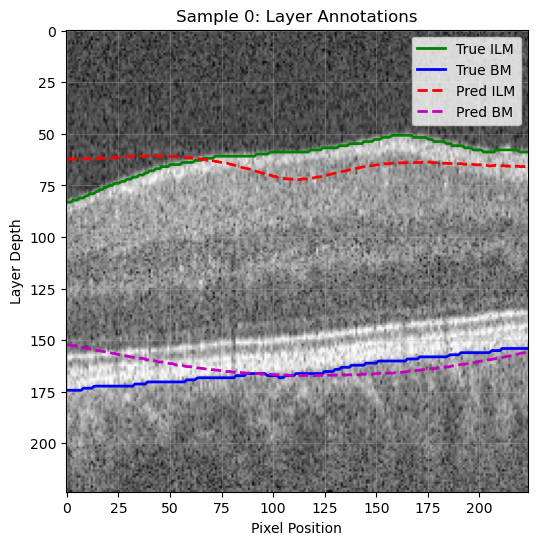

Sample 0 - ILM MAE: 9.8628, BM MAE: 6.3526
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


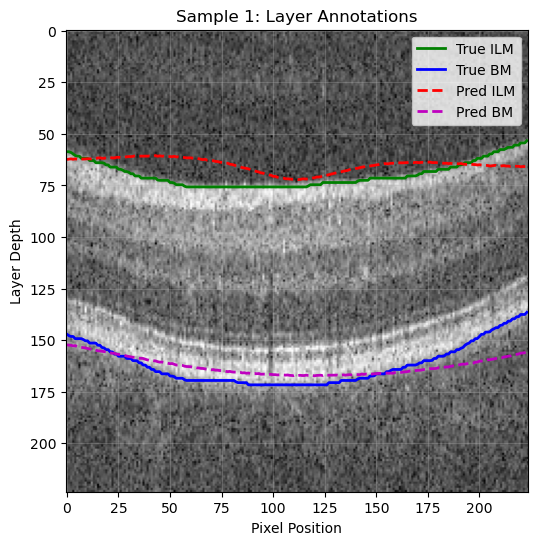

Sample 1 - ILM MAE: 6.6900, BM MAE: 5.4081
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


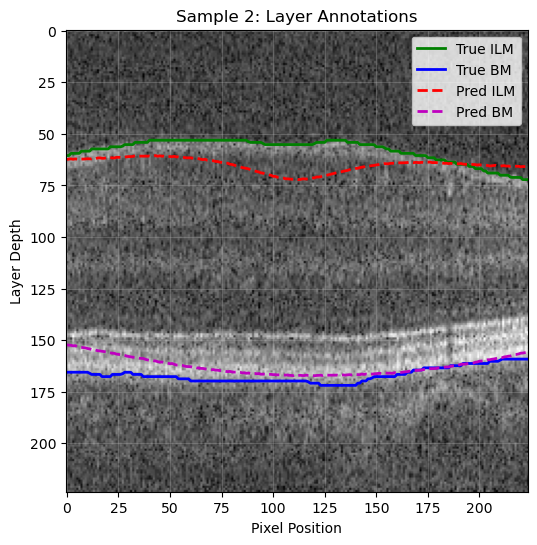

Sample 2 - ILM MAE: 8.1959, BM MAE: 4.4859


In [14]:
import matplotlib.pyplot as plt

layer_min = 0  # e.g., 0
layer_max = 224  # e.g., 224

def denormalize_layers(layers, layer_min, layer_max):
    return layers * (layer_max - layer_min) + layer_min

def plot_layer_annotations(model, images, layer_maps, features, num_samples=5):
    """
    Plot actual and predicted layer annotations for a few samples.
    """
    for idx in range(num_samples):
        img = images[idx]
        true_layers = denormalize_layers(layer_maps[idx], layer_min, layer_max)
        # Model expects batch dimension
        pred_layers = model.predict(features[idx:idx+1])[0]
        pred_layers = denormalize_layers(pred_layers, layer_min, layer_max)

        plt.figure(figsize=(10, 6))
        plt.imshow(img[:, :, 0], cmap='gray')
        plt.plot(range(224), true_layers[:, 0], 'g-', linewidth=2, label='True ILM')
        plt.plot(range(224), true_layers[:, 1], 'b-', linewidth=2, label='True BM')
        plt.plot(range(224), pred_layers[:, 0], 'r--', linewidth=2, label='Pred ILM')
        plt.plot(range(224), pred_layers[:, 1], 'm--', linewidth=2, label='Pred BM')
        plt.title(f"Sample {idx}: Layer Annotations")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlabel('Pixel Position')
        plt.ylabel('Layer Depth')
        plt.show()
        
        # Calculate and print errors for this sample
        mae_ilm = np.mean(np.abs(pred_layers[:, 0] - true_layers[:, 0]))
        mae_bm = np.mean(np.abs(pred_layers[:, 1] - true_layers[:, 1]))
        print(f"Sample {idx} - ILM MAE: {mae_ilm:.4f}, BM MAE: {mae_bm:.4f}")

# Plot predictions on test samples
print("Plotting layer annotations for test samples...")
plot_layer_annotations(swin_regression_model, X_test, y_test, X_test_features, num_samples=3)
